In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import json
import pprint
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel, DistilBertTokenizer, TFDistilBertModel

loadDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\GWStance-master/'
loadFName = 'GWSD.tsv'
bertModelStr = 'bert-base-uncased'

rawData = pd.read_csv(loadDir + loadFName, sep='\t')
labeledInds = np.where(rawData['disagree'].notnull() == True)[0] # use only labeled examples
allSents = rawData.iloc[labeledInds]['sentence']
allLabels = rawData.iloc[labeledInds][['disagree', 'agree', 'neutral']].idxmax(axis=1)

In [2]:
# take a look at raw data
rawData.iloc[5:10] # first 5 examples are unlabeled calibration examples

,Unnamed: 0,round,batch,sent_id,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,disagree,agree,neutral,guid,in_held_out_test
5,5,1,0,t0,Warmer-than-normal sea surface temperatures ar...,neutral,neutral,neutral,agrees,agrees,agrees,agrees,agrees,0.003105,0.711260,0.285634,1_0_t0,False
6,6,1,0,t1,We will continue to rely in part on fossil fue...,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000830,0.001163,0.998006,1_0_t1,False
7,7,1,0,t10,The actual rise in sea levels measured only 1....,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,0.000802,0.001174,0.998023,1_0_t10,False
8,8,1,0,t11,Claims of global warming have been greatly exa...,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,0.997695,0.001171,0.001134,1_0_t11,False
9,9,1,0,t12,The Intergovernmental Panel on Climate Change ...,neutral,disagrees,neutral,neutral,neutral,neutral,neutral,neutral,0.031351,0.002962,0.965687,1_0_t12,False


In [5]:
# split data into train, dev, and test sets (test examples are pre-deterimned by authors' labels)
devSize = 0.2

trainIds = rawData.loc[labeledInds].loc[rawData['in_held_out_test']==False].index.values
x_train, x_dev, y_trainStrs, y_devStrs = train_test_split(allSents.loc[trainIds].tolist(), allLabels.loc[trainIds].tolist()
                                                  , test_size=devSize, random_state=1214)

testIds = rawData.loc[labeledInds].loc[rawData['in_held_out_test']==True].index.values
x_test = allSents.loc[testIds].tolist()
y_testStrs = allLabels.loc[testIds].tolist()

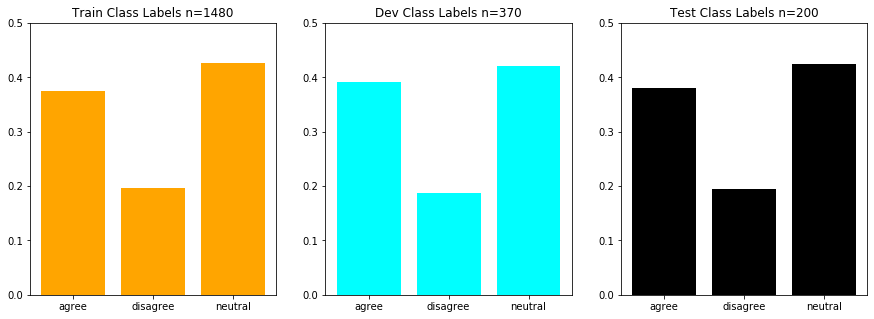

In [6]:
# class distributions
datasets = [y_trainStrs, y_devStrs, y_testStrs]
plotColors = ['orange', 'cyan', 'black']
titles = ['Train', 'Dev', 'Test']

fig = plt.figure(figsize=(15,5))

for datasetNum in np.arange(len(datasets)):
    fig.add_subplot(1,3,datasetNum+1)
    labels, counts = np.unique(datasets[datasetNum], return_counts=True)
    plt.bar(labels, counts/sum(counts), color=plotColors[datasetNum])
    plt.ylim([0, 0.5])
    plt.title(titles[datasetNum] + ' Class Labels n=' + str(len(datasets[datasetNum])))

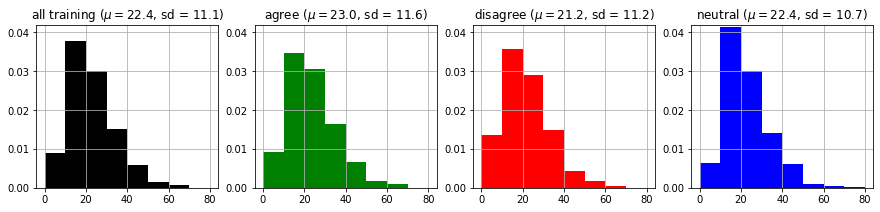

In [7]:
# number of tokens by class

allClassStrs = ['all training', 'agree', 'disagree', 'neutral']
plotColors = ['black', 'green', 'red', 'blue']

# get encodings
tokenizer = BertTokenizer.from_pretrained(bertModelStr)
train_encodings = tokenizer(allSents.loc[trainIds].tolist(), padding=False)

fig, axesH = plt.subplots(1, 4, figsize=(15,3))

for classStr in allClassStrs:
    if classStr == 'all training':
        numTokens = np.array([len(example)-2 for example in train_encodings['input_ids']]) # -2 to discount start [CLS] and end [SEP] tokens
    else:
        classInds = [ind for ind, label in enumerate(allLabels.loc[trainIds].tolist()) if label == classStr]
        classTokenIds = [train_encodings['input_ids'][ind] for ind in classInds]
        numTokens = np.array([len(example)-2 for example in classTokenIds])
                          
    listInd = allClassStrs.index(classStr)
    axesH[listInd].hist(numTokens, bins = np.linspace(0, 80, num=9), color = plotColors[listInd], density=True)
    axesH[listInd].set_title(classStr 
                             + ' ($\mu=$' + str(np.round(np.mean(numTokens), 1)) 
                             + ', sd = ' + str(np.round(np.std(numTokens), 1)) + ')'
                            )
    axesH[listInd].set_ylim([0,0.042])
    axesH[listInd].grid(True)

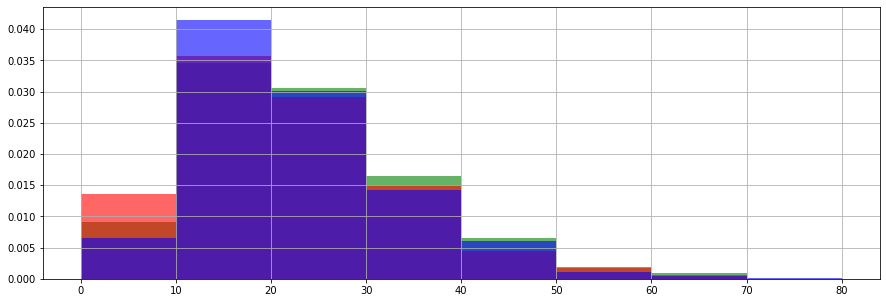

In [8]:
# number of tokens by class (overlapping)

allClassStrs = ['agree', 'disagree', 'neutral']
plotColors = ['green', 'red', 'blue']

fig = plt.figure(figsize=(15,5))

for classStr in allClassStrs:
    classInds = [ind for ind, label in enumerate(allLabels.loc[trainIds].tolist()) if label == classStr]
    classTokenIds = [train_encodings['input_ids'][ind] for ind in classInds]
    numTokens = np.array([len(example)-2 for example in classTokenIds]) # -2 to discount start [CLS] and end [SEP] tokens
                          
    listInd = allClassStrs.index(classStr)
    plt.hist(numTokens, bins = np.linspace(0, 80, num=9), color = plotColors[listInd], density=True, alpha=0.6)
    plt.grid(True)

## Plot most frequent tokens by class

In [195]:
allClassStrs = ['agree', 'disagree', 'neutral']

# initiate dictionary with all tokens across all training examples
flatTokenIds = [token for example in train_encodings['input_ids'] for token in tokenizer.convert_ids_to_tokens(example)]
tokenDensitiesDict = dict((token, [0, 0, 0]) for token in list(dict(Counter(flatTokenIds)).keys()))

for classStr in allClassStrs:
    classInds = [ind for ind, label in enumerate(allLabels.loc[trainIds].tolist()) if label == classStr]
    classTokenIds = [train_encodings['input_ids'][ind] for ind in classInds]
    flatTokenIds = [token for example in classTokenIds for token in tokenizer.convert_ids_to_tokens(example)]
    classTokenCounts = dict(Counter(flatTokenIds))
    
    classListInd = allClassStrs.index(classStr)
    numSents = len(classInds)
    for token in list(numTokensDict.keys()):
        if token in classTokenCounts.keys():
            tokenDensitiesDict[token][classListInd] = classTokenCounts[token]/numSents

In [226]:
tokenDensitiesDf = pd.DataFrame.from_dict(tokenDensitiesDict, orient='index'
                                          , columns=allClassStrs)

# reorder by largest (absolute value) density differences between 'agree' and 'disagree' sentences
tokenDensitiesDf['agreeMinusDisagree'] =  tokenDensitiesDf['agree'] - tokenDensitiesDf['disagree']
tokenDensitiesDf = tokenDensitiesDf.reindex(tokenDensitiesDf.agreeMinusDisagree.abs().sort_values(ascending=False).index)

,agree,disagree,neutral,agreeMinusDisagree
",",0.686163,0.479224,0.602792,0.206938
the,1.012839,0.850416,0.974619,0.162423
to,0.664765,0.518006,0.555838,0.146759
and,0.490728,0.360111,0.383249,0.130617
warming,0.372325,0.498615,0.195431,-0.126290
of,0.617689,0.509695,0.615482,0.107994
not,0.062767,0.166205,0.081218,-0.103438
change,0.253923,0.152355,0.139594,0.101568
is,0.419401,0.512465,0.331218,-0.093065
we,0.099857,0.019391,0.039340,0.080467


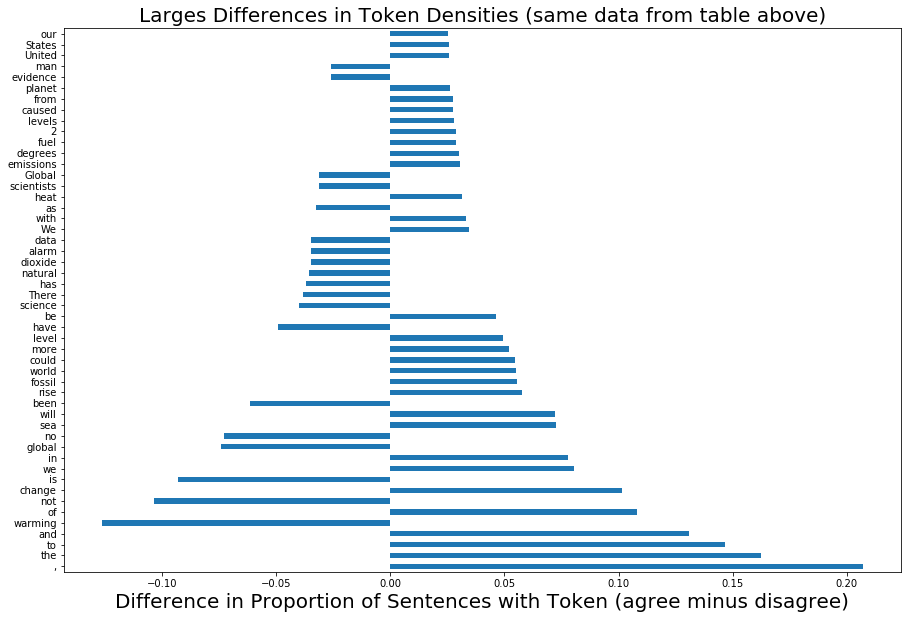

In [230]:
topNTokens = 50

figH = plt.figure(figsize=(15,10))

tokenDensitiesDf.iloc[0:topNTokens]['agreeMinusDisagree'].plot.barh()
plt.xlabel('Difference in Proportion of Sentences with Token (agree minus disagree)', fontsize=20)
plt.title('Larges Differences in Token Densities (same data from table above)', fontsize=20)
tokenDensitiesDf.head(topNTokens)

**Conclusions:** 'agree' sentences seem to be longer based on highest difference being a comma. None of the other tokens seem to have particularly large enough differences to make a difference on classification. May be useful to run same analysis using n-grams instead of single tokens.

### Put Number of Tokens in a df to use as a feature 

In [12]:
allEncodings = tokenizer(allSents.tolist(), padding=False)
numTokens = np.array([len(example)-2 for example in allEncodings['input_ids']]) # -2 to discount start [CLS] and end [SEP] tokens

featuresDf = pd.DataFrame(allLabels, columns=['label'])
featuresDf['numTokens'] = numTokens

In [47]:
# unsampled t-test and effect sizes between two classes
sample1 = featuresDf.where(featuresDf.label=='agree').dropna()['numTokens']
sample2 = featuresDf.where(featuresDf.label=='disagree').dropna()['numTokens']

def print_ttest_cohensD(sample1, sample2):
    tstats = scipy.stats.ttest_ind(sample1, sample2)

    pooledStd = np.sqrt((np.std(sample1)**2 + np.std(sample2)**2) / 2)
    cohensD = (np.mean(sample1) - np.mean(sample2))/pooledStd

    print('t-value: ' + str(round(tstats.statistic, 7))
          + '\np-value: ' + str(round(tstats.pvalue, 7))
          + '\nCohen\'s D: ' + str(round(cohensD, 7))
         )
    
print_ttest_cohensD(sample1, sample2)

t-value: 2.7275518
p-value: 0.0064757
Cohen's D: 0.1687621


# Sentiment Scores

## Sentiment Scores using Bert

In [15]:
# either load or calculate sentiment scores
import os

saveLoadDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'sentimentScores_distilbert.json'

if os.path.isfile(saveLoadDir + fileName):
    with open(saveLoadDir + fileName, 'r') as file:
        sentimentOutput = json.load(file)
else:    
    # get sentiment scores (using BERT)
    sentimentClassifier = pipeline('sentiment-analysis', framework='tf', device=0)
    sentimentOutput = sentimentClassifier(allSents.tolist())    

    # save to json
    saveLoadDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
    fileName = 'sentimentScores_distilbert.json'

    with open(saveLoadDir + fileName, 'w') as fout:
        json.dump(sentimentOutput , fout)
        
# put sentiment scores and labels in a dataframe
allSentScores = [sentence['score'] for sentence in sentimentOutput]

# adjust confidence scores to be used as a feature
for ind in np.arange(len(allSentScores)):
    allSentScores[ind] = allSentScores[ind] - (1-allSentScores[ind]) # subtract probability of opposite class (changes lims to [0 1])
    
    if sentimentOutput[ind]['label'] == 'NEGATIVE': # flip sign of negative scores
        allSentScores[ind] = -allSentScores[ind]
        
# put sentiment scores in featuresDf
featuresDf['bertSent'] = allSentScores
featuresDf.groupby('label').mean()

,numTokens,bertSent
label,,
agree,23.038610,-0.195645
disagree,21.125000,-0.461165
neutral,22.434135,-0.201133


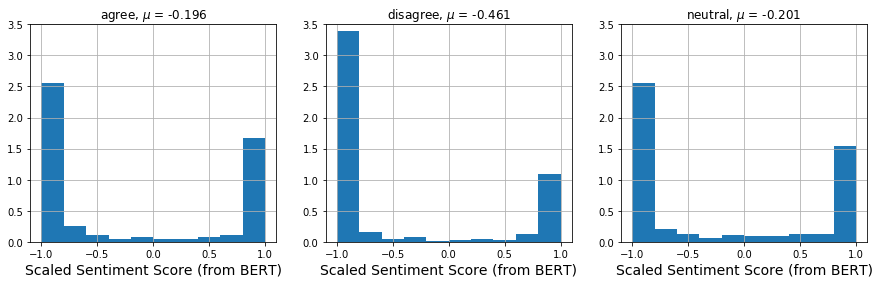

In [42]:
# check distributions of scaled sentiment scores

classStrs = ['agree', 'disagree', 'neutral']

figH, axesH = plt.subplots(1, 3, figsize=(15,4))

for classStr in classStrs:
    axesH[classStrs.index(classStr)].hist(featuresDf.where(featuresDf.label==classStr).dropna()['bertSent'], density=True)
    axesH[classStrs.index(classStr)].grid(True)
    axesH[classStrs.index(classStr)].set_title(classStr + ', $\mu$ = ' + str(np.round(np.mean(featuresDf.where(featuresDf.label==classStr).dropna()['bertSent']), 3)))
    axesH[classStrs.index(classStr)].set_ylim([0, 3.5])
    axesH[classStrs.index(classStr)].set_xlabel('Scaled Sentiment Score (from BERT)', fontsize=14)

In [25]:
tstats.statistic

4.9340083236128125

In [45]:
# unsampled t-test and effect sizes between sentiment scores of classes 
sample1 = featuresDf.where(featuresDf.label=='agree').dropna()['bertSent']
sample2 = featuresDf.where(featuresDf.label=='disagree').dropna()['bertSent']
    
print_ttest_cohensD(sample1, sample2)

t-value: 4.9340083
p-value: 9e-07
Cohen's D: 0.3081711


In [35]:
# print examples of sentences with labels and sentiment scores
sortedInds = np.argsort(allSentScores)
printInds = sortedInds[:10]

for ind in printInds:
    if allLabels.iloc[ind] == 'agree' or allLabels.iloc[ind] == 'disagree':
        pprint.pprint(allSents.iloc[ind] + '  ' + allLabels.iloc[ind] + '  sentScore: ' + str(round(allSentScores[ind], 5)))

('The standard global warming narrative is stale and alienating — and perhaps '
 'worst of all, stuck in the technical weeds.  disagree  sentScore: -0.99963')
('The climate scare will soon lose credibility as global warming.  disagree  '
 'sentScore: -0.99962')
('Antibiotics are losing their effectiveness at a rate that is both alarming '
 'and irreversible — similar to global warming.  agree  sentScore: -0.99961')
'Global warming is already making it worse.  agree  sentScore: -0.99959'
("Anthropogenic warming theory just didn't stand up.  disagree  sentScore: "
 '-0.99959')
('Attributing specific climatic events to global warming is simply dishonest.  '
 'disagree  sentScore: -0.99958')
('Unfortunately, the Trump administration has become a rogue outlier in its '
 'shortsighted attempt to prop up the dirty fossil fuel industries of the '
 'past.  agree  sentScore: -0.99957')
'The shoddy and absurd climate change plan.  disagree  sentScore: -0.99957'
('Divestment will not contribute to

## Sentiment Scores from SentiWordNet (sentiment lexicon)

In [37]:
# get sentiwordnet scores for each example in dataset
from nltk.corpus import sentiwordnet as swn

tokenizer = BertTokenizer.from_pretrained(bertModelStr)

allSentScores = []

for sentStr in allSents.tolist():
    tokens = tokenizer.tokenize(sentStr)
    scoresList = []
    
    for word in tokens:
        if not list(swn.senti_synsets(word)):
            None # exclude unknown tokens
        else:
            # currently using very crude method: take the first score of each word (using a pos-tagger would be more accurate)
            sentScoreDiff = list(swn.senti_synsets(word))[0].pos_score() - list(swn.senti_synsets(word))[0].neg_score()
            scoresList.append(sentScoreDiff)
            
    allSentScores.append(np.mean(scoresList))
    
featuresDf['swnet_zscored'] = scipy.stats.zscore(allSentScores)
featuresDf.groupby('label').mean()

,numTokens,bertSent,swnet_zscored
label,,,
agree,23.038610,-0.195645,-0.047983
disagree,21.125000,-0.461165,-0.214200
neutral,22.434135,-0.201133,0.140851


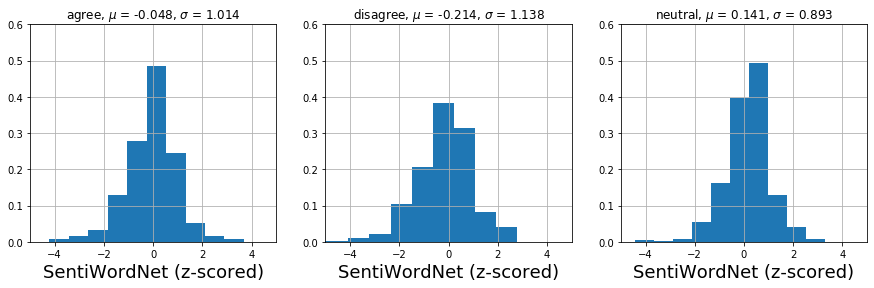

In [40]:
# check distributions of scaled sentiment scores

classStrs = ['agree', 'disagree', 'neutral']

figH, axesH = plt.subplots(1, 3, figsize=(15,4))

for classStr in classStrs:
    axesH[classStrs.index(classStr)].hist(featuresDf.where(featuresDf.label==classStr).dropna()['swnet_zscored'], density=True)
    axesH[classStrs.index(classStr)].grid(True)
    axesH[classStrs.index(classStr)].set_title(classStr 
                                               + ', $\mu$ = ' + str(np.round(np.mean(featuresDf.where(featuresDf.label==classStr).dropna()['swnet_zscored']), 3))
                                               + ', $\sigma$ = ' + str(np.round(np.std(featuresDf.where(featuresDf.label==classStr).dropna()['swnet_zscored']), 3))
                                              )
    axesH[classStrs.index(classStr)].set_ylim([0, 0.6])
    axesH[classStrs.index(classStr)].set_xlim([-5, 5])
    axesH[classStrs.index(classStr)].set_xlabel('SentiWordNet (z-scored)', fontsize=18)

In [46]:
# unsampled t-test and effect sizes between sentiment scores of classes 
sample1 = featuresDf.where(featuresDf.label=='agree').dropna()['swnet_zscored']
sample2 = featuresDf.where(featuresDf.label=='disagree').dropna()['swnet_zscored']

print_ttest_cohensD(sample1, sample2)

t-value: 2.5520103
p-value: 0.010836
Cohen's D: 0.154251


## Save featuresDf to CSV to be used for training models

In [73]:
saveDir = r'C:\Users\mz1391\Downloads\Masters_Berkeley_MIDS\W266_NLP_Deep_Learning\Final_Project\saved_files/'
fileName = 'engineeredFeatures.csv'

featuresDf.to_csv(saveDir+fileName, index_label='id')